# January 2026, Louisa Hizli
Download Data from Robert J. Shillers Website to Analyze Returns and Return Compositions of Equity and Housing

In [50]:
# Imports 
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Function to download Shiller data from the web and save locally
def download_excel_data(url, sheet_name, local_filename):
    """
    Download an Excel file from a URL (if not already downloaded)
    and return a specific sheet as pandas DataFrame.

    Args: url (str): Direct URL to the Excel file (.xls or .xlsx).
          sheet_name (str): Name of the sheet to load.
          local_filename (str): Local path to save the Excel file.
    
    Returns:
        pd.DataFrame: The requested sheet as a pandas DataFrame.   
    """

    # Download the file only it does not exist locally
    if not os.path.exists(local_filename):
        print("Downloading {local_filename} from {url}...")
        response = requests.get(url)
        response.raise_for_status()  # Check for request errors
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print("Download complete.")
    else:
        print(f"File {local_filename} already exists. Skipping download.")
    
    # Load the Excel file
    xls = pd.ExcelFile(local_filename)

    # Check if the requested sheet exists
    if sheet_name not in xls.sheet_names:
        raise ValueError(f"Sheet '{sheet_name}' not found in the Excel file. Available sheets: {xls.sheet_names}")
    
    # Load the specified sheet into a DataFrame
    df = pd.read_excel(xls, sheet_name=sheet_name)

    return df

# Equity Data

## Download and Import Shiller Equity Data (S&P)

In [ ]:
# Download Shiller Equity Data (S&P)
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/1b9b0a8a-aa83-40bc-a151-c19ef387b564/ie_data.xls?ver=1767626365966"
local_filename = "shiller_data_equity.xls"
sheet_name = "Data"

shiller_equity_df = download_excel_data(url, sheet_name, local_filename)

# Delete up to and including row 5
shiller_equity_df = shiller_equity_df.iloc[6:].reset_index(drop=True)

# Set first row as header
shiller_equity_df.columns = shiller_equity_df.iloc[0]
shiller_equity_df = shiller_equity_df.iloc[1:].reset_index(drop=True)



File shiller_data_equity.xls already exists. Skipping download.


## Calculate Returns and Return Decomposition
Returns are calculated following Jorda et al. 2019
By definition, total return equals payoff divided by cost
Payoffs are capital gains (price change) plus capital income (dividend yield)

$R_t = \frac{p_t - p_{t-1}}{p_{t-1}} + y_t$

Let 

$\pi_t = \frac{\text{CPI}_t - \text{CPI}_{t-1}}{\text{CPI}_{t-1}}$

be the realized consumer price inflation rate.

The inflation-adjusted real return is

$r_t = \frac{1 + R_t}{1 + \pi_t} - 1$



In [32]:
# Convert all columns to numeric, coerce errors to NaN
shiller_equity_df = shiller_equity_df.apply(pd.to_numeric, errors="coerce")

# Capital gain
shiller_equity_df["capital_gain"] = shiller_equity_df["P"].pct_change()

# Dividend yield (Shiller's D is annual, price is monthly)
shiller_equity_df["dividend_yield"] = (shiller_equity_df["D"] / 12) / shiller_equity_df["P"]

# Nominal total return
shiller_equity_df["total_return"] = (
    shiller_equity_df["capital_gain"] +
    shiller_equity_df["dividend_yield"]
)

# Inflation
shiller_equity_df["inflation"] = shiller_equity_df["CPI"].pct_change()

# Real return (Fisher equation, approx)
shiller_equity_df["real_return"] = (
    (1 + shiller_equity_df["total_return"]) /
    (1 + shiller_equity_df["inflation"])
) - 1

# Real capital gain
shiller_equity_df["real_capital_gain"] = (
    (1 + shiller_equity_df["capital_gain"]) /
    (1 + shiller_equity_df["inflation"])
) - 1

# Real dividend yield
shiller_equity_df["real_dividend_yield"] = (
    (1 + shiller_equity_df["dividend_yield"]) /
    (1 + shiller_equity_df["inflation"])
) - 1


/var/folders/h7/cgjpd0n52wjb_dmfwymyd4x00000gn/T/ipykernel_11042/2660088518.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  shiller_equity_df["inflation"] = shiller_equity_df["CPI"].pct_change()


## Convert to Yearly Data 1960-2025
Currently data is monthly from 1870.1-2026.1\
Convert to yearly by taking\
Geometric mean for returns, arithmetic mean for levels

In [51]:
# Ensure column names are strings
shiller_equity_df.columns = shiller_equity_df.columns.astype(str)

# Extract year from decimal Date
shiller_equity_df["year"] = shiller_equity_df["Date"].astype(int)

# Return columns (geometric mean)
return_cols = [
    "real_return",
    "total_return",
    "capital_gain",
    "real_capital_gain",
    "dividend_yield",
    "real_dividend_yield",
    "inflation"
]

# Level columns (arithmetic mean)
level_cols = [c for c in shiller_equity_df.columns if c not in return_cols + ["Date", "year"]]

# Convert return columns to float
shiller_equity_df[return_cols] = shiller_equity_df[return_cols].astype(float)

# Define geometric mean function
def geom_mean(series):
    series = series.dropna()
    return (1 + series).prod() - 1 if len(series) > 0 else np.nan

# Function to aggregate one group
def aggregate_group(group):
    result = {}
    # geometric mean for returns
    for col in return_cols:
        result[col] = geom_mean(group[col])
    # arithmetic mean for levels
    for col in level_cols:
        result[col] = group[col].mean()
    return pd.Series(result)

# Apply per year
annual_shiller_equity_df = shiller_equity_df.groupby("year").apply(aggregate_group).reset_index()

# Filter to 1960–2025
annual_shiller_equity_df = annual_shiller_equity_df[
    (annual_shiller_equity_df["year"] >= 1960) &
    (annual_shiller_equity_df["year"] <= 2025)
]

print(annual_shiller_equity_df.head())




    year  real_return  total_return  capital_gain  real_capital_gain  \
90  1960    -0.017590     -0.004224     -0.038266          -0.051175   
91  1961     0.291537      0.300205      0.263028           0.254608   
92  1962    -0.108703     -0.096819     -0.126847          -0.138336   
93  1963     0.201600      0.221363      0.184068           0.164908   
94  1964     0.154213      0.165419      0.131994           0.121110   

    dividend_yield  real_dividend_yield  inflation          P         D  ...  \
90        0.035267             0.021371   0.013605  55.850000  1.937500  ...   
91        0.030025             0.023158   0.006711  66.272500  1.959167  ...   
92        0.033943             0.020339   0.013333  62.382500  2.068333  ...   
93        0.031945             0.015246   0.016447  69.865000  2.197500  ...   
94        0.029833             0.019931   0.009709  81.368333  2.394167  ...   

                                                Price   Dividend  \
90  0
Price      6

/var/folders/h7/cgjpd0n52wjb_dmfwymyd4x00000gn/T/ipykernel_11042/1874719802.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_shiller_equity_df = shiller_equity_df.groupby("year").apply(aggregate_group).reset_index()


In [ ]:






# Filter years 1960–2025
annual_shiller_equity_df = annual_shiller_equity_df[
    (annual_shiller_equity_df["year"] >= 1960) &
    (annual_shiller_equity_df["year"] <= 2025)
]

print(annual_shiller_equity_df.head())



AttributeError: 'DataFrame' object has no attribute 'name'

## Plot Returns and Return Decomposition


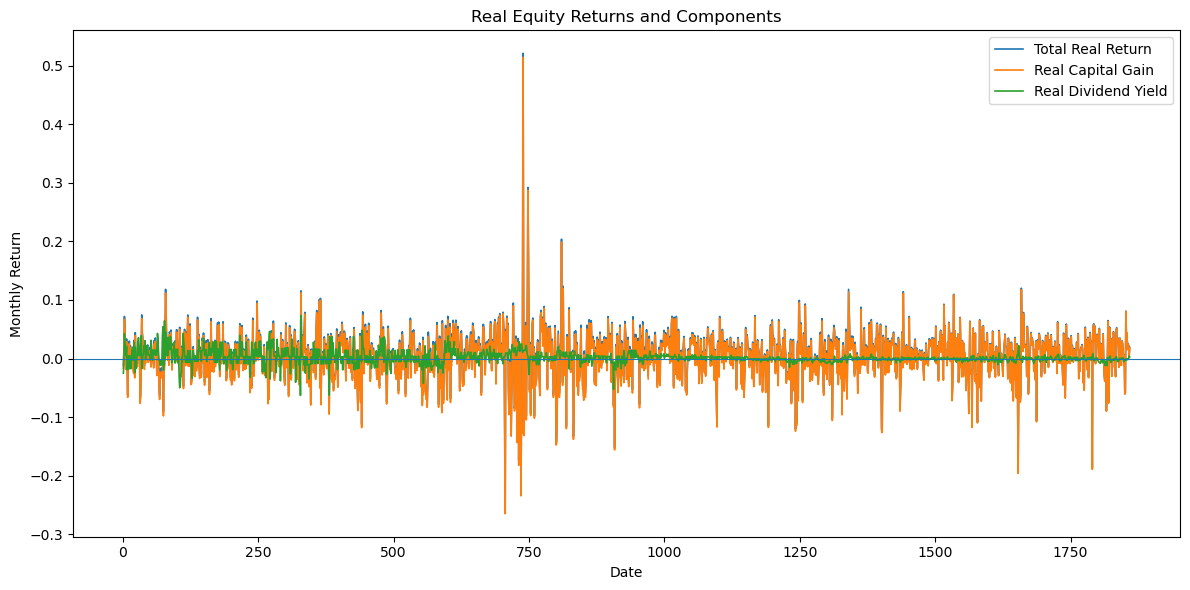

In [33]:
cols_to_plot = [
    "real_return",
    "real_capital_gain",
    "real_dividend_yield"
]

shiller_equity_df[cols_to_plot].dropna().plot(
    figsize=(12, 6),
    linewidth=1.2
)

plt.title("Real Equity Returns and Components")
plt.ylabel("Monthly Return")
plt.xlabel("Date")
plt.axhline(0, linewidth=0.8)
plt.legend([
    "Total Real Return",
    "Real Capital Gain",
    "Real Dividend Yield"
])

plt.tight_layout()
plt.show()